# Load data

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sage

In [2]:
# Load data
df = sage.datasets.bank()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()[:-1]
categorical_cols = [
    "Job",
    "Marital",
    "Education",
    "Default",
    "Housing",
    "Loan",
    "Contact",
    "Month",
    "Prev Outcome",
]
categorical_inds = [feature_names.index(col) for col in categorical_cols]

In [3]:
# Split data
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=123
)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=123
)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

In [4]:
test.shape

(4521, 16)

# Train model

In [5]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss

In [6]:
model = CatBoostClassifier(iterations=100, learning_rate=0.3, depth=10)

model = model.fit(
    train, Y_train, categorical_inds, eval_set=(val, Y_val), verbose=False
)

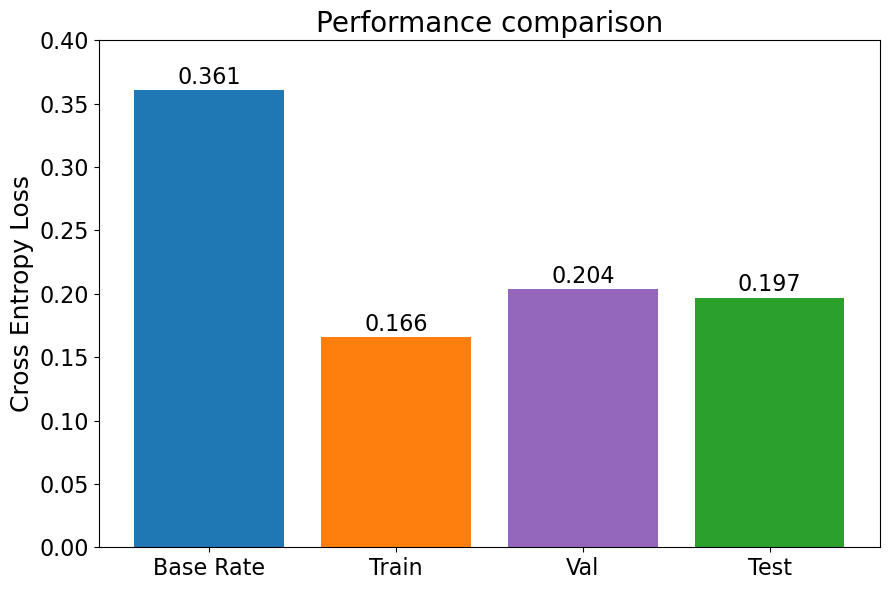

In [7]:
# Calculate performance
p = np.array([np.sum(Y_train == i) for i in np.unique(Y_train)]) / len(Y_train)
base_ce = log_loss(Y_test, p[np.newaxis].repeat(len(test), 0))
train_ce = log_loss(Y_train, model.predict_proba(train))
val_ce = log_loss(Y_val, model.predict_proba(val))
test_ce = log_loss(Y_test, model.predict_proba(test))

# Plot
plt.figure(figsize=(9, 6))
plt.bar(
    np.arange(4),
    [base_ce, train_ce, val_ce, test_ce],
    color=["tab:blue", "tab:orange", "tab:purple", "tab:green"],
)

ax = plt.gca()
for i, ce in enumerate([base_ce, train_ce, val_ce, test_ce]):
    ax.text(i - 0.17, ce + 0.005, "{:.3f}".format(ce), fontsize=16)

plt.ylim(0, 0.4)

plt.xticks(np.arange(4), ["Base Rate", "Train", "Val", "Test"])
plt.tick_params(labelsize=16)
plt.ylabel("Cross Entropy Loss", fontsize=18)
plt.title("Performance comparison", fontsize=20)

plt.tight_layout()
plt.show()

# Global Method

## SIM-Shapley

In [8]:
from sim_shapley import imputers, estimator
from sim_shapley.utils import crossentropyloss

In [9]:
sim_imputer = imputers.MarginalImputer(model, train[:512], sample_num=10)
sim_estimator = estimator.SIM_Shapley(train[:512], sim_imputer, crossentropyloss, l2_penalty=0.01, t=0.55)
sim_value = sim_estimator(test[:2000], Y_test[:2000], 80, 512, thresh=0.025)

  0%|          | 0/1 [00:00<?, ?it/s]

Convergence detected! Gap is 0.024912517937000615.


<BarContainer object of 16 artists>

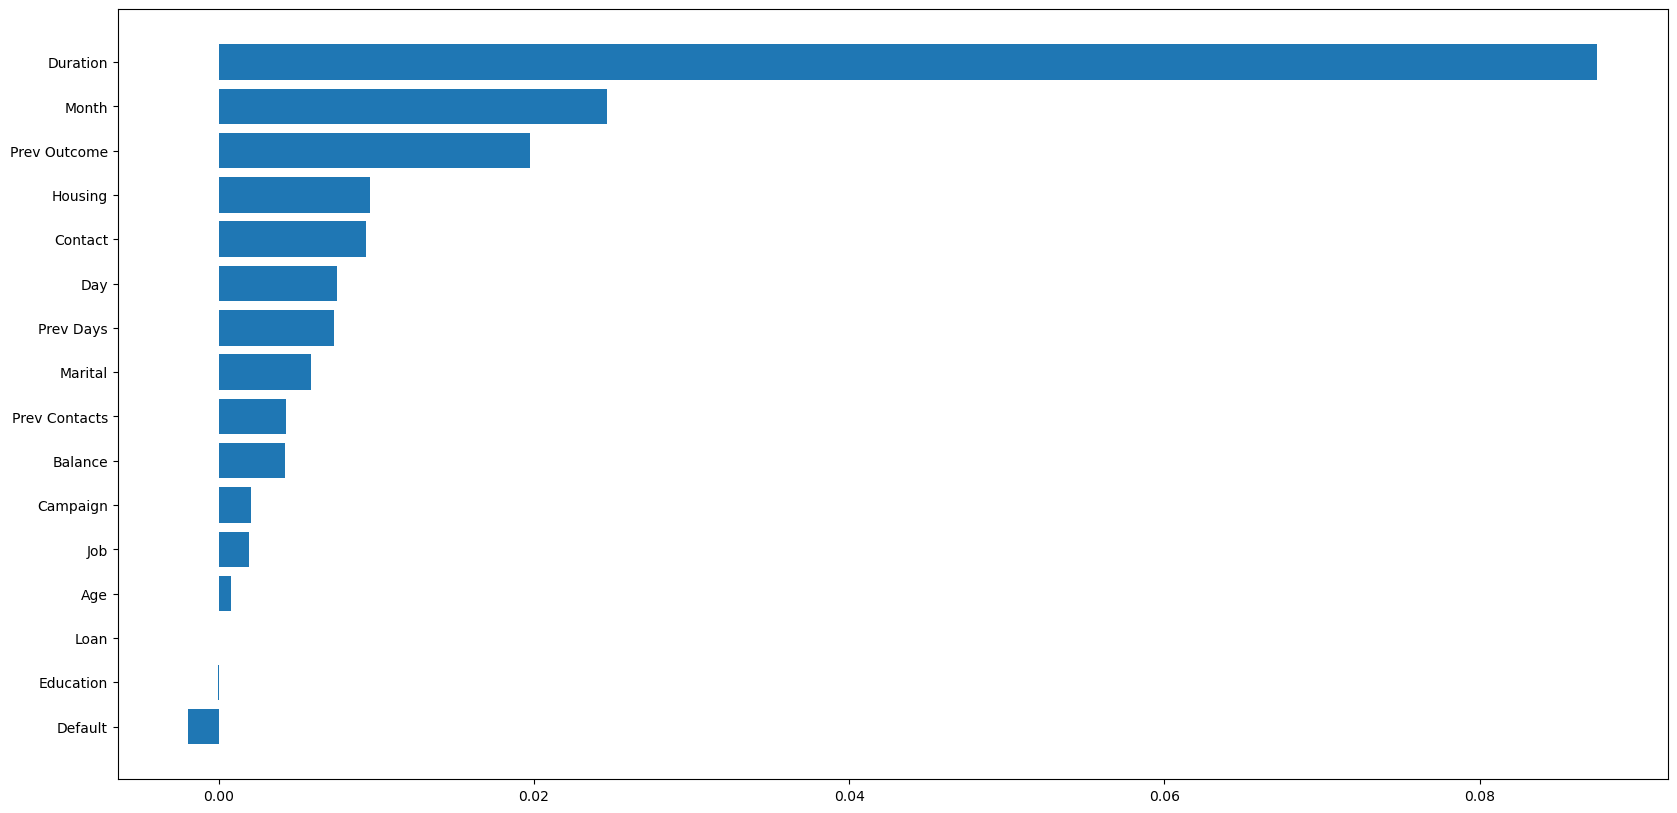

In [10]:
a = dict(zip(feature_names, sim_value))
sorted(a.items(), key=lambda kv: (kv[1], kv[0]), reverse=True)
m = sorted(a.items(), key=lambda kv: (kv[1], kv[0]))
plt.figure(figsize=(20, 10))
plt.barh([k[0] for k in m], [k[1] for k in m])

## SAGE

In [11]:
imputer = sage.MarginalImputer(model, train[:512])
sage_estimator = sage.PermutationEstimator(imputer, "cross entropy", n_jobs=-1)
sage_values = sage_estimator(test[:2000], Y_test[:2000], thresh=0.025)

PermutationEstimator will use 16 jobs


  0%|          | 0/1 [00:00<?, ?it/s]

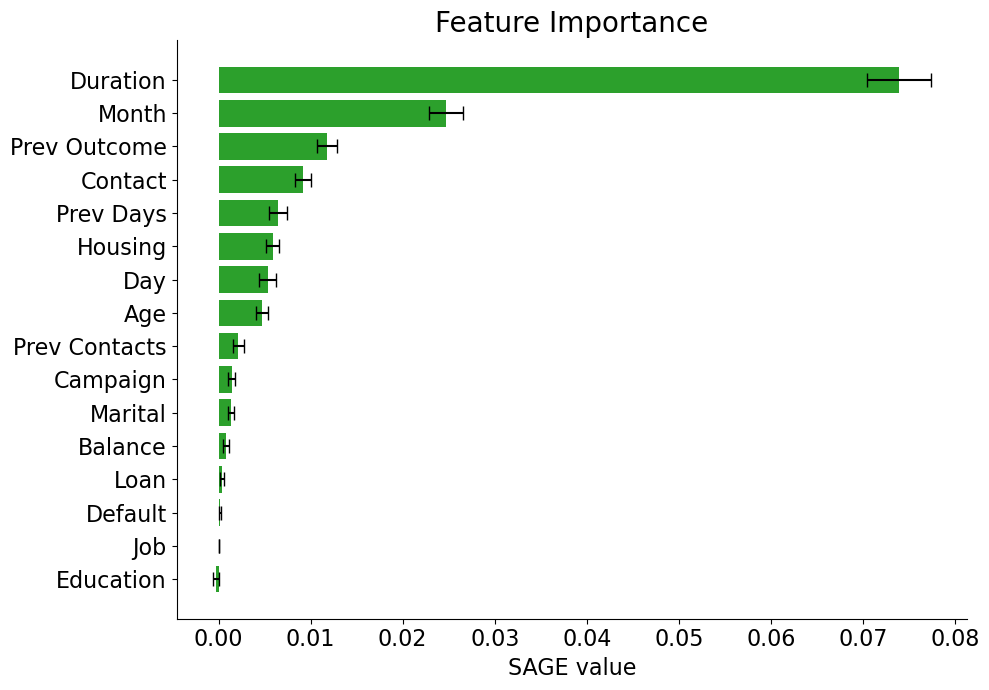

In [12]:
sage_values.plot(feature_names)

## Comparison

In [13]:
import scipy.stats as st
from scipy.stats import wasserstein_distance

In [14]:
# Pearson Correlation
st.pearsonr(sage_values.values, sim_value)[0]

0.9911278856424958

In [15]:
# wasserstein_distance
wasserstein_distance(sim_value, sage_values.values)

0.0024009897307538663

# Local Method

## SIM-Shapley

In [16]:
from sim_shapley import imputers, estimator
from sim_shapley.utils import crossentropyloss

In [17]:
sim_imputer = imputers.MarginalImputer(model, train[:512], sample_num=100)
sim_estimator = estimator.SIM_Shapley(train[:512], sim_imputer, crossentropyloss, l2_penalty=0.01, t=0.5, method_type='local')
sim_value = sim_estimator(test[10], Y_test[10], 80, 512, thresh=0.01)

  0%|          | 0/1 [00:00<?, ?it/s]

Convergence detected! Gap is 0.009855230439516397.


<BarContainer object of 16 artists>

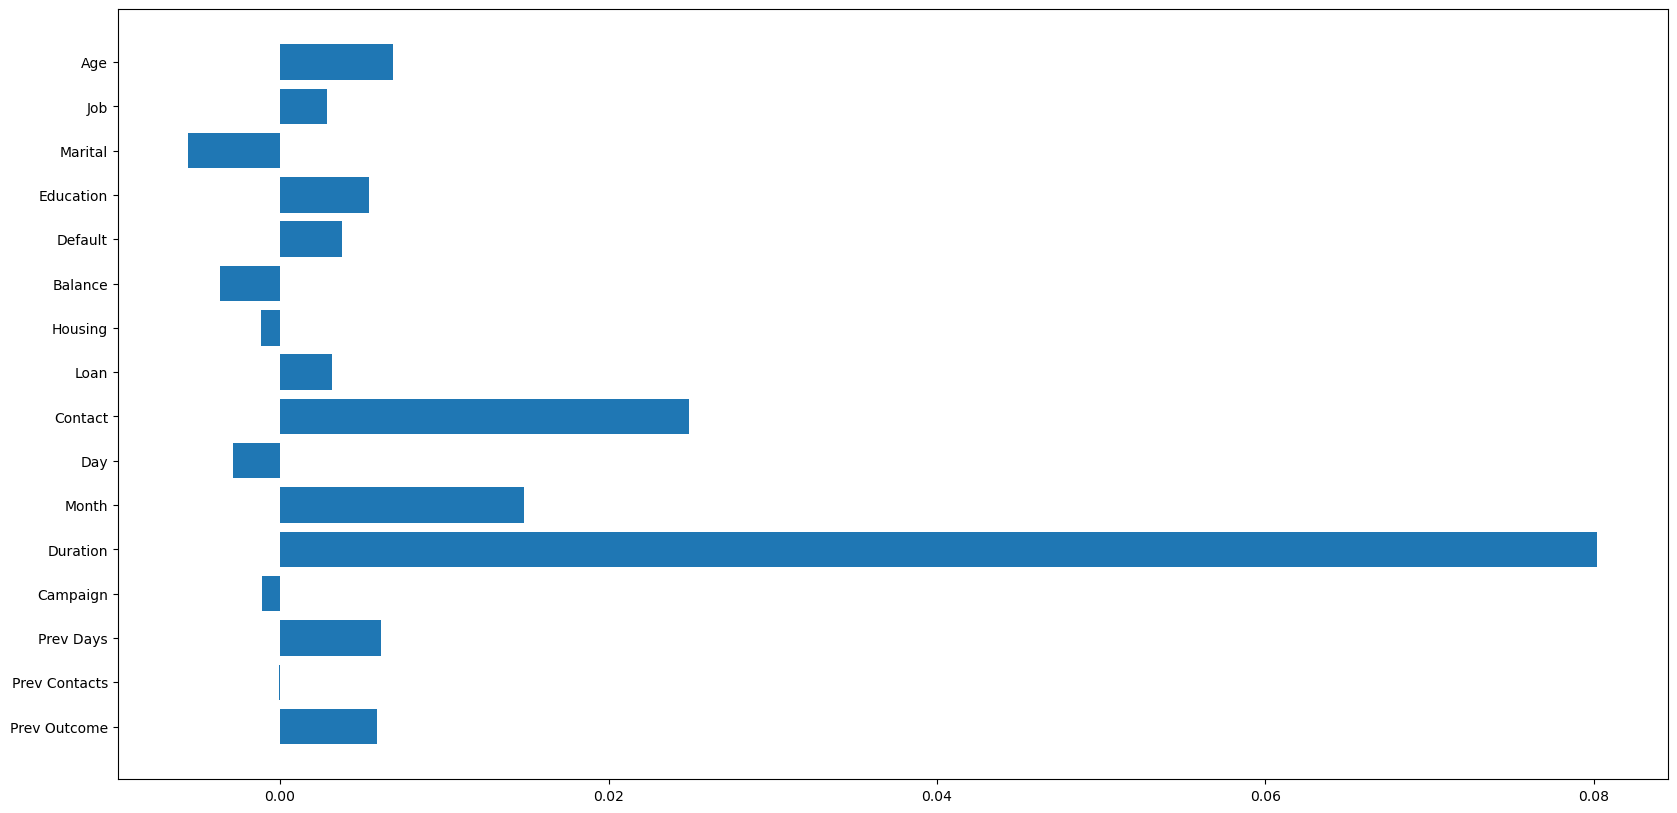

In [18]:
plt.figure(figsize=(20, 10))
plt.barh(feature_names[::-1], sim_value[::-1])

## KernelSHAP

In [19]:
from shapreg.utils import crossentropyloss
from shapreg import removal, games, shapley

# Make model callable
model_lam = lambda x: model.predict_proba(x)

# Model extension
marginal_extension = removal.MarginalExtension(train[:512], model_lam)
# Set up game

game = games.PredictionLossGame(marginal_extension, test[10], Y_test[10], crossentropyloss)
explanation = shapley.ShapleyRegression(game, paired_sampling=False)

  0%|          | 0/1 [00:00<?, ?it/s]

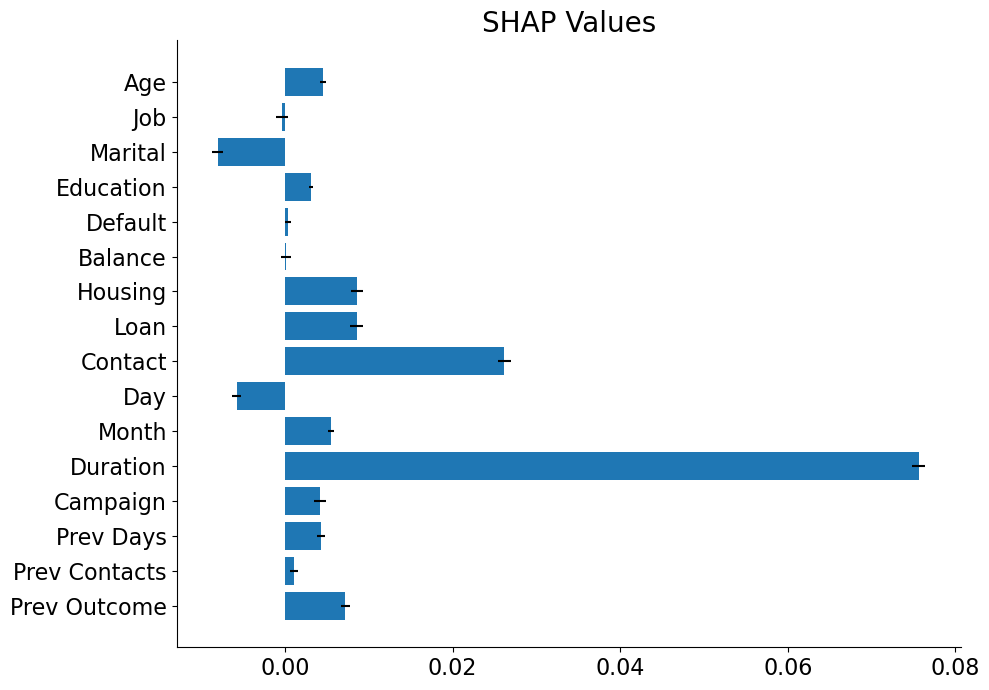

In [20]:
explanation.plot(feature_names, title='SHAP Values', sort_features=False)

## Comparison

In [21]:
import scipy.stats as st
from scipy.stats import wasserstein_distance

In [22]:
# Pearson Correlation
st.pearsonr(explanation.values, sim_value)[0]

0.9738101211233441

In [23]:
# wasserstein_distance
wasserstein_distance(sim_value, explanation.values)

0.001801744400476322